Epoch 1/20 - Loss: 2.3026, Accuracy: 0.2500
Epoch 2/20 - Loss: 2.3013, Accuracy: 0.2500
Epoch 3/20 - Loss: 2.3041, Accuracy: 0.0625
Epoch 4/20 - Loss: 2.3018, Accuracy: 0.1875
Epoch 5/20 - Loss: 2.3027, Accuracy: 0.0625
Epoch 6/20 - Loss: 2.3017, Accuracy: 0.2500
Epoch 7/20 - Loss: 2.3024, Accuracy: 0.0625
Epoch 8/20 - Loss: 2.3014, Accuracy: 0.2500
Epoch 9/20 - Loss: 2.3037, Accuracy: 0.0625
Epoch 10/20 - Loss: 2.3036, Accuracy: 0.0625
Epoch 11/20 - Loss: 2.3023, Accuracy: 0.1250
Epoch 12/20 - Loss: 2.3017, Accuracy: 0.1250
Epoch 13/20 - Loss: 2.3024, Accuracy: 0.1875
Epoch 14/20 - Loss: 2.3028, Accuracy: 0.1250
Epoch 15/20 - Loss: 2.3028, Accuracy: 0.0625
Epoch 16/20 - Loss: 2.3022, Accuracy: 0.1250
Epoch 17/20 - Loss: 2.3025, Accuracy: 0.1250
Epoch 18/20 - Loss: 2.3029, Accuracy: 0.0625
Epoch 19/20 - Loss: 2.3035, Accuracy: 0.0000
Epoch 20/20 - Loss: 2.3026, Accuracy: 0.1250
Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step - accuracy: 0.0963 - loss: 2.3021 - val_accuracy: 0.1300

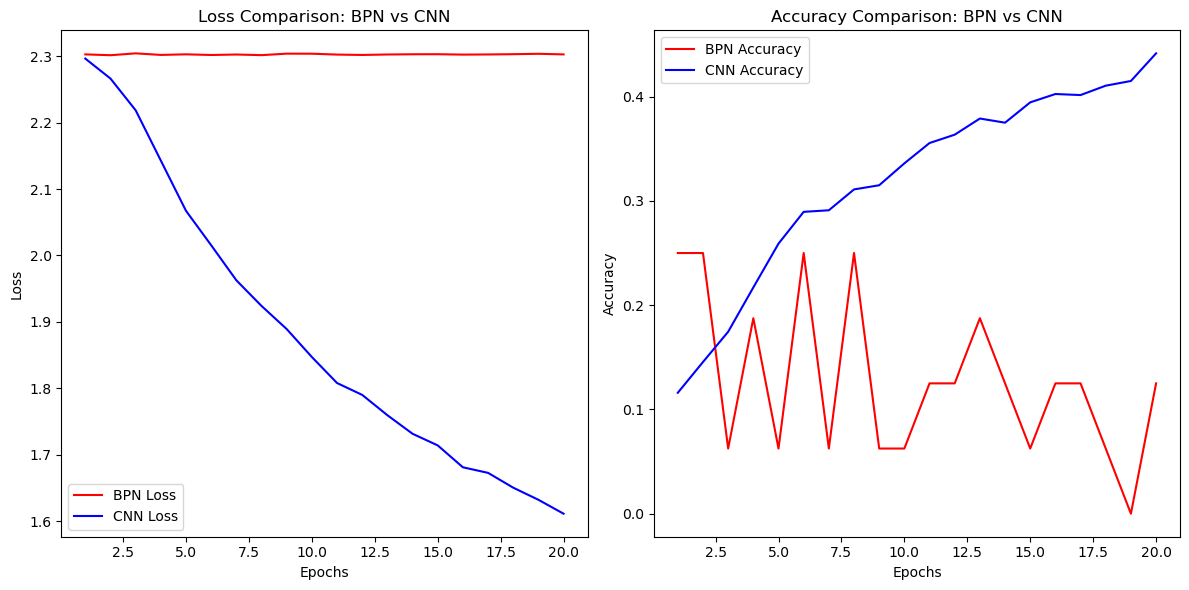

BPN Final Accuracy: 12.50%
CNN Final Accuracy: 44.15%


In [5]:
import numpy as np
import random
from keras.datasets import cifar10
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import tensorflow as tf
from tensorflow.keras import layers, models

# --- Load CIFAR-10 dataset ---
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Use 10000 images for training and 500 for testing
X_train, y_train = X_train[:10000], y_train[:10000]
X_test, y_test = X_test[:500], y_test[:500]

# Normalize the images
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# One-hot encode labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# --- Manual Data Augmentation --- 
def random_flip(x):
    """Randomly flip an image horizontally."""
    if random.random() < 0.5:
        return np.fliplr(x)
    return x

def random_rotation(x, max_angle=20):
    """Randomly rotate an image."""
    angle = random.uniform(-max_angle, max_angle)
    return rotate(x, angle, reshape=False)

def augment_images(X, y, augment_count=2000):
    """Augment dataset with random flips and rotations."""
    X_augmented = []
    y_augmented = []
    
    for i in range(augment_count):
        img = X[i]
        label = y[i]
        
        # Apply random flip and rotation
        img = random_flip(img)
        img = random_rotation(img)
        
        X_augmented.append(img)
        y_augmented.append(label)
    
    return np.array(X_augmented), np.array(y_augmented)

# Apply augmentation
X_train_aug, y_train_aug = augment_images(X_train, y_train, augment_count=2000)

# --- Activation Functions ---
def relu(x):
    return np.maximum(0, x)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_deriv(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))  # For numerical stability
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

def cross_entropy_loss(y_pred, y_true):
    m = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred + 1e-8)) / m  # Adding small epsilon for numerical stability

# --- Batch Normalization ---
def batch_normalization(x):
    mean = np.mean(x, axis=0)
    var = np.var(x, axis=0)
    return (x - mean) / np.sqrt(var + 1e-8)

# --- Fully Connected Neural Network (BPN) Model ---
class BPN:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate=0.001):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.learning_rate = learning_rate

        # Initialize weights and biases
        self.weights = []
        self.biases = []
        prev_size = self.input_size
        for hidden_size in self.hidden_sizes:
            self.weights.append(np.random.randn(prev_size, hidden_size) * 0.01)
            self.biases.append(np.zeros((1, hidden_size)))
            prev_size = hidden_size
        self.weights.append(np.random.randn(prev_size, self.output_size) * 0.01)
        self.biases.append(np.zeros((1, self.output_size)))

    def forward(self, X):
        self.a = [X]
        self.z = []
        for i in range(len(self.weights)):
            z = np.dot(self.a[i], self.weights[i]) + self.biases[i]
            self.z.append(z)
            a = leaky_relu(z) if i < len(self.weights) - 1 else softmax(z)
            self.a.append(a)
        return self.a[-1]

    def backward(self, X, y):
        m = X.shape[0]
        dz = self.a[-1] - y
        dw = np.dot(self.a[-2].T, dz) / m
        db = np.sum(dz, axis=0, keepdims=True) / m
        grads = [(dw, db)]

        for i in range(len(self.weights) - 2, -1, -1):
            dz = np.dot(dz, self.weights[i + 1].T) * leaky_relu_deriv(self.a[i + 1])
            dw = np.dot(self.a[i].T, dz) / m
            db = np.sum(dz, axis=0, keepdims=True) / m
            grads.append((dw, db))
        grads.reverse()

        return grads

    def update(self, grads):
        for i in range(len(self.weights)):
            dw, db = grads[i]
            self.weights[i] -= self.learning_rate * dw
            self.biases[i] -= self.learning_rate * db

    def train(self, X, y, epochs, batch_size):
        loss_history = []
        accuracy_history = []
        
        for epoch in range(epochs):
            perm = np.random.permutation(X.shape[0])
            X_shuffled = X[perm]
            y_shuffled = y[perm]
            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]
                output = self.forward(X_batch)
                grads = self.backward(X_batch, y_batch)
                self.update(grads)

            if epoch % 1 == 0:  # Collecting data after every epoch
                loss = cross_entropy_loss(output, y_batch)
                accuracy = self.accuracy(output, y_batch)
                loss_history.append(loss)
                accuracy_history.append(accuracy)
                print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
        
        return loss_history, accuracy_history

    def accuracy(self, y_pred, y_true):
        correct = np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1)
        return np.mean(correct)

# --- Convolutional Neural Network (CNN) Model ---
class CNN:
    def __init__(self, input_shape, learning_rate=0.0001):
        self.input_shape = input_shape
        self.learning_rate = learning_rate
        
        self.model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dense(10, activation='softmax')
        ])
        
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

    def train(self, X, y, epochs, batch_size):
        history = self.model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)
        return history.history['loss'], history.history['accuracy']

# --- Train and evaluate both models ---
bpn = BPN(input_size=3072, hidden_sizes=[512, 256], output_size=10, learning_rate=0.0001)
bpn_loss, bpn_acc = bpn.train(X_train_aug.reshape(2000, 3072), y_train_aug, epochs=20, batch_size=64)

cnn_model = CNN(input_shape=(32, 32, 3), learning_rate=0.0001)
cnn_loss, cnn_acc = cnn_model.train(X_train_aug, y_train_aug, epochs=20, batch_size=64)

# --- Plotting the results ---
epochs = np.arange(1, 21)

# Plot loss comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, bpn_loss, label='BPN Loss', color='red')
plt.plot(epochs, cnn_loss, label='CNN Loss', color='blue')
plt.title('Loss Comparison: BPN vs CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy comparison
plt.subplot(1, 2, 2)
plt.plot(epochs, bpn_acc, label='BPN Accuracy', color='red')
plt.plot(epochs, cnn_acc, label='CNN Accuracy', color='blue')
plt.title('Accuracy Comparison: BPN vs CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# --- Final Results ---
print(f"BPN Final Accuracy: {bpn_acc[-1]*100:.2f}%")
print(f"CNN Final Accuracy: {cnn_acc[-1]*100:.2f}%")


Epoch 1/20 - Loss: 2.3026, Accuracy: 0.1875
Epoch 2/20 - Loss: 2.3028, Accuracy: 0.0625
Epoch 3/20 - Loss: 2.3048, Accuracy: 0.0000
Epoch 4/20 - Loss: 2.3030, Accuracy: 0.1875
Epoch 5/20 - Loss: 2.3020, Accuracy: 0.1875
Epoch 6/20 - Loss: 2.3032, Accuracy: 0.1250
Epoch 7/20 - Loss: 2.3014, Accuracy: 0.1875
Epoch 8/20 - Loss: 2.3052, Accuracy: 0.0000
Epoch 9/20 - Loss: 2.3027, Accuracy: 0.0625
Epoch 10/20 - Loss: 2.3020, Accuracy: 0.0625
Epoch 11/20 - Loss: 2.3027, Accuracy: 0.0625
Epoch 12/20 - Loss: 2.3021, Accuracy: 0.1875
Epoch 13/20 - Loss: 2.3022, Accuracy: 0.1250
Epoch 14/20 - Loss: 2.3041, Accuracy: 0.0000
Epoch 15/20 - Loss: 2.3016, Accuracy: 0.1250
Epoch 16/20 - Loss: 2.3034, Accuracy: 0.1250
Epoch 17/20 - Loss: 2.3037, Accuracy: 0.0000
Epoch 18/20 - Loss: 2.3025, Accuracy: 0.1250
Epoch 19/20 - Loss: 2.3015, Accuracy: 0.3125
Epoch 20/20 - Loss: 2.3030, Accuracy: 0.1250
Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 148ms/step - accuracy: 0.1061 - loss: 2.3029 - val_accuracy: 0.1460

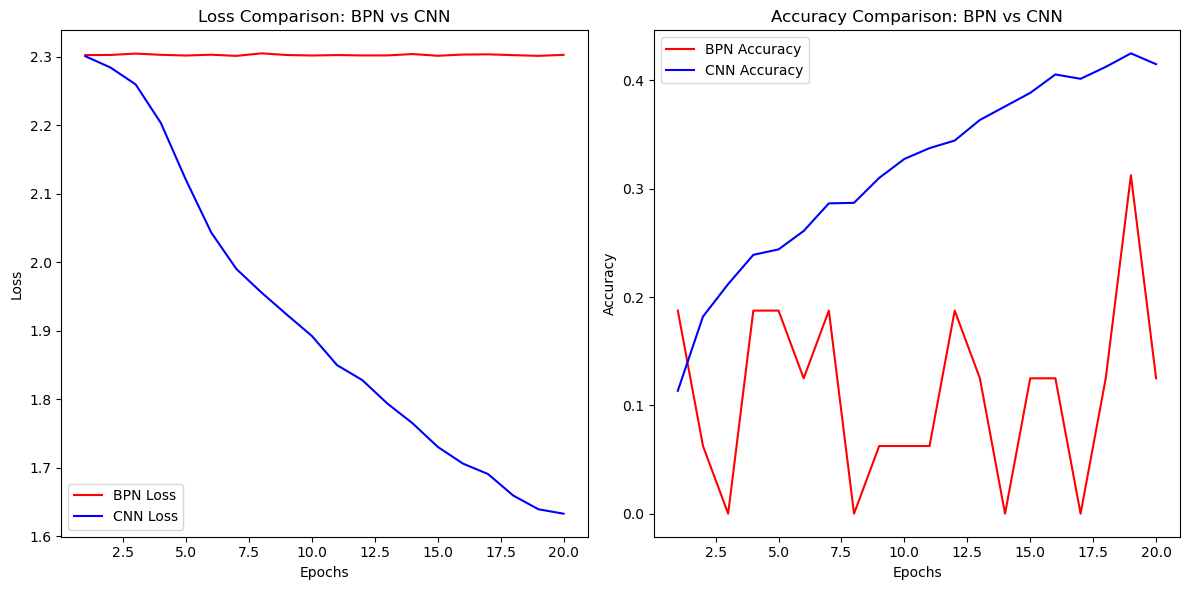

BPN Final Accuracy: 12.50%
CNN Final Accuracy: 41.50%


In [2]:
import numpy as np
import random
from keras.datasets import cifar10
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import tensorflow as tf
from tensorflow.keras import layers, models

# --- Load CIFAR-10 dataset ---
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Use 2000 images for training and 500 for testing
X_train, y_train = X_train[:2000], y_train[:2000]
X_test, y_test = X_test[:500], y_test[:500]

# Normalize the images
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# One-hot encode labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# --- Manual Data Augmentation --- 
def random_flip(x):
    """Randomly flip an image horizontally."""
    if random.random() < 0.5:
        return np.fliplr(x)
    return x

def random_rotation(x, max_angle=20):
    """Randomly rotate an image."""
    angle = random.uniform(-max_angle, max_angle)
    return rotate(x, angle, reshape=False)

def augment_images(X, y, augment_count=2000):
    """Augment dataset with random flips and rotations."""
    X_augmented = []
    y_augmented = []
    
    for i in range(augment_count):
        img = X[i]
        label = y[i]
        
        # Apply random flip and rotation
        img = random_flip(img)
        img = random_rotation(img)
        
        X_augmented.append(img)
        y_augmented.append(label)
    
    return np.array(X_augmented), np.array(y_augmented)

# Apply augmentation
X_train_aug, y_train_aug = augment_images(X_train, y_train, augment_count=2000)

# --- Activation Functions ---
def relu(x):
    return np.maximum(0, x)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_deriv(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))  # For numerical stability
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

def cross_entropy_loss(y_pred, y_true):
    m = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred + 1e-8)) / m  # Adding small epsilon for numerical stability

# --- Batch Normalization ---
def batch_normalization(x):
    mean = np.mean(x, axis=0)
    var = np.var(x, axis=0)
    return (x - mean) / np.sqrt(var + 1e-8)

# --- Fully Connected Neural Network (BPN) Model ---
class BPN:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate=0.001):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.learning_rate = learning_rate

        # Initialize weights and biases
        self.weights = []
        self.biases = []
        prev_size = self.input_size
        for hidden_size in self.hidden_sizes:
            self.weights.append(np.random.randn(prev_size, hidden_size) * 0.01)
            self.biases.append(np.zeros((1, hidden_size)))
            prev_size = hidden_size
        self.weights.append(np.random.randn(prev_size, self.output_size) * 0.01)
        self.biases.append(np.zeros((1, self.output_size)))

    def forward(self, X):
        self.a = [X]
        self.z = []
        for i in range(len(self.weights)):
            z = np.dot(self.a[i], self.weights[i]) + self.biases[i]
            self.z.append(z)
            a = leaky_relu(z) if i < len(self.weights) - 1 else softmax(z)
            self.a.append(a)
        return self.a[-1]

    def backward(self, X, y):
        m = X.shape[0]
        dz = self.a[-1] - y
        dw = np.dot(self.a[-2].T, dz) / m
        db = np.sum(dz, axis=0, keepdims=True) / m
        grads = [(dw, db)]

        for i in range(len(self.weights) - 2, -1, -1):
            dz = np.dot(dz, self.weights[i + 1].T) * leaky_relu_deriv(self.a[i + 1])
            dw = np.dot(self.a[i].T, dz) / m
            db = np.sum(dz, axis=0, keepdims=True) / m
            grads.append((dw, db))
        grads.reverse()

        return grads

    def update(self, grads):
        for i in range(len(self.weights)):
            dw, db = grads[i]
            self.weights[i] -= self.learning_rate * dw
            self.biases[i] -= self.learning_rate * db

    def train(self, X, y, epochs, batch_size):
        loss_history = []
        accuracy_history = []
        
        for epoch in range(epochs):
            perm = np.random.permutation(X.shape[0])
            X_shuffled = X[perm]
            y_shuffled = y[perm]
            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]
                output = self.forward(X_batch)
                grads = self.backward(X_batch, y_batch)
                self.update(grads)

            if epoch % 1 == 0:  # Collecting data after every epoch
                loss = cross_entropy_loss(output, y_batch)
                accuracy = self.accuracy(output, y_batch)
                loss_history.append(loss)
                accuracy_history.append(accuracy)
                print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
        
        return loss_history, accuracy_history

    def accuracy(self, y_pred, y_true):
        correct = np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1)
        return np.mean(correct)

# --- Convolutional Neural Network (CNN) Model ---
class CNN:
    def __init__(self, input_shape, learning_rate=0.0001):
        self.input_shape = input_shape
        self.learning_rate = learning_rate
        
        self.model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dense(10, activation='softmax')
        ])
        
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

    def train(self, X, y, epochs, batch_size):
        history = self.model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)
        return history.history['loss'], history.history['accuracy']

# --- Train and evaluate both models ---
bpn = BPN(input_size=3072, hidden_sizes=[512, 256], output_size=10, learning_rate=0.0001)
bpn_loss, bpn_acc = bpn.train(X_train_aug.reshape(2000, 3072), y_train_aug, epochs=20, batch_size=64)

cnn_model = CNN(input_shape=(32, 32, 3), learning_rate=0.0001)
cnn_loss, cnn_acc = cnn_model.train(X_train_aug, y_train_aug, epochs=20, batch_size=64)

# --- Plotting the results ---
epochs = np.arange(1, 21)

# Plot loss comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, bpn_loss, label='BPN Loss', color='red')
plt.plot(epochs, cnn_loss, label='CNN Loss', color='blue')
plt.title('Loss Comparison: BPN vs CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy comparison
plt.subplot(1, 2, 2)
plt.plot(epochs, bpn_acc, label='BPN Accuracy', color='red')
plt.plot(epochs, cnn_acc, label='CNN Accuracy', color='blue')
plt.title('Accuracy Comparison: BPN vs CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# --- Final Results ---
print(f"BPN Final Accuracy: {bpn_acc[-1]*100:.2f}%")
print(f"CNN Final Accuracy: {cnn_acc[-1]*100:.2f}%")
